In [1]:
%load_ext autoreload
%autoreload 2
binary = True


import datetime
import gudhi
import numpy as np
import pandas as pd

from functions.data_processing import sublevelset_persistence, remove_outliers_z_score, remove_outliers_dbscan
from functions.data_loading import get_condensed_distance_matrix, flights_from_query, get_flight_persistances
from functions.plotting import plot_scatter_matrix

from scipy.cluster.hierarchy import fcluster, linkage
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from traffic.core import Traffic, Flight

In [1]:
# load minimum data set
df = pd.read_csv("data/go_arounds_augmented.csv", low_memory=False)
df["time"] = pd.to_datetime(df["time"])

start = datetime.datetime(year=2019, month=1, day=1).replace(
)
stop = datetime.datetime(year=2019, month=6, day=1).replace(
    tzinfo=datetime.timezone.utc
)

NameError: name 'pd' is not defined

C:\Users\tobso\Desktop\programering\masters-thesis\venv1\Lib\site-packages\matplotlib\axes\_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


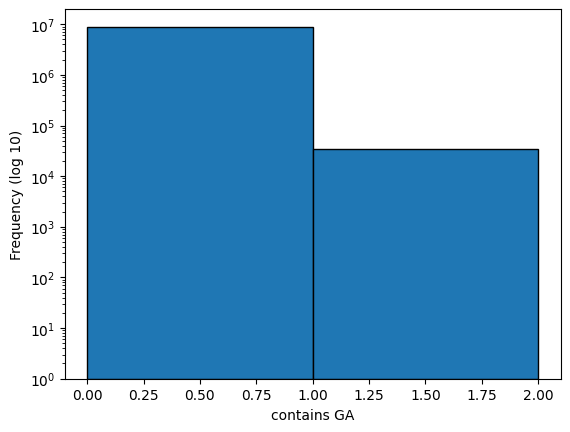

In [3]:
if binary:
    data = (df["n_approaches"] != 1)
    bins = np.arange(0, max(data) + 2)
else:
    data = (df["n_approaches"])
    bins = np.arange(1, max(data) + 2)

plt.figure()
plt.hist(data, log=True, bins=bins, edgecolor = "black", bottom=1)

plt.ylabel("Frequency (log 10)")

if binary:
    plt.xlabel("contains GA")
    plt.savefig("./Thesis plots/experiment2/binary_approach_histogram.svg", format="svg")
else:
    plt.xlabel("Number of approaches")
    plt.savefig("./Thesis plots/experiment3/approach_histogram.svg", format="svg")
#plt.close()

In [4]:
approach_1 = df.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = df.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = df.query(f"n_approaches==3 & (@start <= time <= @stop)")
approach_4 = df.query(f"n_approaches==4 & (@start <= time <= @stop)")

len_4 = approach_4.shape[0]
len_3 = approach_3.shape[0]
len_2 = (len_4 + len_3) * 2
len_1 = (len_4 + len_3 + len_2) * 2

approach_4 = approach_4.sample(n=len_4, random_state=42)
approach_3 = approach_3.sample(n=len_3, random_state=42)
approach_2 = approach_2.sample(n=len_2, random_state=42)
approach_1 = approach_1.sample(n=len_1, random_state=42)

query = pd.concat([approach_1, approach_2, approach_3, approach_4], axis=0)

C:\Users\tobso\Desktop\programering\masters-thesis\venv1\Lib\site-packages\matplotlib\axes\_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


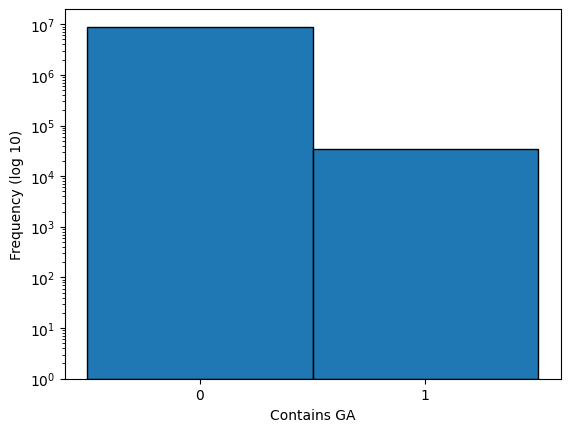

In [5]:
if binary:
    data = df["n_approaches"] != 1
    bins = np.arange(0, max(data) + 2)
else:
    data = query["n_approaches"]
    bins = np.arange(1, max(data) + 2)


fig, ax = plt.subplots()
sampled_hist, bin_edges, _ = ax.hist(data, bins=bins, log=True, edgecolor="black", bottom=1)

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.set_xticks(bin_centers)
ax.set_xticklabels([str(int(x)) for x in bin_centers])  # optional: force integer labels

ax.set_xlabel("Contains GA")
ax.set_ylabel("Frequency (log 10)")

if binary:
    plt.savefig("./Thesis plots/experiment2/binary_approach_histogram.svg", format="svg", bbox_inches="tight")
else:
    plt.savefig("./Thesis plots/experiment3/unbalanced_approach_histogram.svg", format="svg", bbox_inches="tight")

baseline_ylim = ax.get_ylim()

In [6]:
train, test = train_test_split(query, train_size=0.8, test_size=0.2, random_state=42)

In [7]:
file_name = "unbalanced_train"
flights, train_labels, stats = flights_from_query(train, file_name, load_results=False)
data = get_flight_persistances(flights, file_name, load_results=False)

100%|██████████| 4261/4261 [00:16<00:00, 264.05it/s]


In [ ]:
file_name = "unbalanced_test"
flights, test_labels, stats = flights_from_query(test, file_name, load_results=False)
data = get_flight_persistances(flights, file_name, load_results=False)

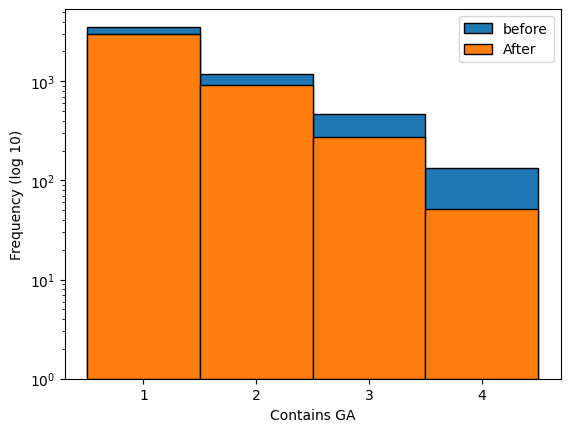

In [9]:
binary = False
if binary:
    before_data = train["n_approaches"] != 1
    after_data = (train_labels[:, 0] != 1)
    bins =np.arange(0, max(before_data) + 2)
else:
    before_data = train["n_approaches"]
    after_data = train_labels[:, 0]
    bins = np.arange(1, max(before_data) + 2)

fig, ax = plt.subplots(nrows=1, ncols=1)
sampled_hist, bin_edges, p = ax.hist(before_data, bins=bins, log=True, edgecolor="black", bottom=1)
p.set_label("before")

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.set_xticks(bin_centers)
ax.set_xticklabels([str(int(x)) for x in bin_centers])  # optional: force integer labels

ax.set_xlabel("Contains GA")
ax.set_ylabel("Frequency (log 10)")

baseline_ylim = ax.get_ylim()

data = train_labels[:, 0] != 1
sampled_hist, bin_edges, p = ax.hist(after_data, bins=bins, log=True, edgecolor="black", bottom=1)
p.set_label("After")
ax.legend()

if binary:
    plt.savefig("./Thesis plots/experiment2/binary_approach_filter_histogram.svg", format="svg", bbox_inches="tight")
else:
    plt.savefig("./Thesis plots/experiment3/unbalanced_approach_filter_histogram.svg", format="svg", bbox_inches="tight")

In [10]:
(train_labels[:, 0] == 4).sum() / sum(train["n_approaches"] == 4)

0.3787878787878788

In [11]:
fig, ax = plt.subplots()
bins = np.arange(1, max(data) + 2)
train_hist, bin_edges, _ = ax.hist(data, bins=bins, log=True, edgecolor="black")

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.set_xticks(bin_centers)
ax.set_xticklabels([str(int(x)) for x in bin_centers])  # optional: force integer labels

ax.set_ylim(baseline_ylim)
ax.set_xlabel("Contains GA")
ax.set_ylabel("Frequency (log 10)")
plt.savefig("filtered_approach_histogram_approaches.svg", format="svg", bbox_inches="tight")

NameError: name 'filtered_data' is not defined

C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\matplotlib\axes\_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)
C:\Users\tobso\Desktop\programering\masters-thesis\venv\Lib\site-packages\matplotlib\axes\_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


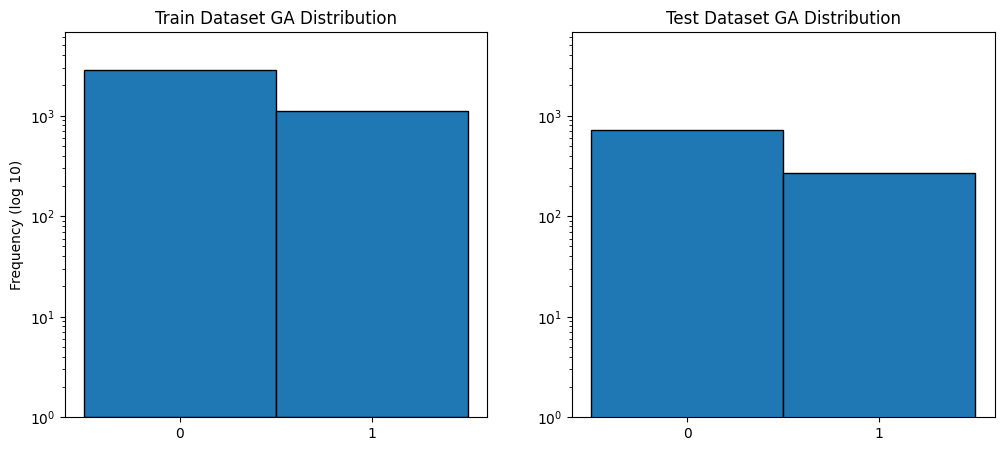

In [119]:
train_data = train_labels[:, 0] > 1
test_data = test_labels[:, 0] > 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
bins = np.arange(0, max(data) + 2)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

train_hist, _, _ = ax1.hist(train_data, log=True, bins=bins, edgecolor = "black", bottom=1)
ax1.set_ylim(baseline_ylim)
ax1.set_ylabel("Frequency (log 10)")
ax1.set_title("Train Dataset GA Distribution")
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([str(int(x)) for x in bin_centers])
ax1.set_xlabel("Contains GA")

test_hist, _, _ = ax2.hist(test_data, log=True, bins=bins, edgecolor = "black")
ax2.set_ylim(baseline_ylim)
ax2.set_title("Test Dataset GA Distribution")
ax2.set_xticks(bin_centers)
ax2.set_xticklabels([str(int(x)) for x in bin_centers])
ax2.set_xlabel("Contains GA")

plt.savefig("split_approach_histogram.svg", format="svg")

In [7]:
approach_1 = train.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = train.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = train.query(f"n_approaches==3 & (@start <= time <= @stop)")

len_3 = approach_3.shape[0]

approach_3 = approach_3.sample(n=len_3, random_state=42)
approach_2 = approach_2.sample(n=len_3, random_state=42)
approach_1 = approach_1.sample(n=len_3, random_state=42)

balanced_train = pd.concat([approach_1, approach_2, approach_3], axis=0)

In [8]:
approach_1 = test.query(f"n_approaches==1 & (@start <= time <= @stop)")
approach_2 = test.query(f"n_approaches==2 & (@start <= time <= @stop)")
approach_3 = test.query(f"n_approaches==3 & (@start <= time <= @stop)")

balanced_test = pd.concat([approach_1, approach_2, approach_3], axis=0)

In [13]:
file_name = "balanced_train"
balanced_train_flights, balanced_train_labels, balanced_train_stats = flights_from_query(balanced_train, file_name, load_results=True)
balanced_train_data = get_flight_persistances(balanced_train_flights, file_name, load_results=False)

100%|██████████| 1041/1041 [00:03<00:00, 261.89it/s]


In [14]:
file_name = "balanced_test"
balanced_test_flights, balanced_test_labels, balanced_test_stats = flights_from_query(balanced_test, file_name, load_results=False)
balanced_test_data = get_flight_persistances(balanced_test_flights, file_name, load_results=False)


RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
RUNNING: : 96.0% [00:08, 934%/s]
FINISHED: : 96.0% [00:09, 934%/s]
FINISHED: : 100% [00:09, 10.8%/s]

DOWNLOAD: 1.80klines [00:00, 189klines/s]
 99%|█████████▉| 1295/1311 [11:31<02:32,  9.53s/it]
0.00% [00:00, ?%/s]
RUNNING: : 0.00% [00:00, ?%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:00, 946%/s]
RUNNING: : 96.3% [00:01, 946%/s]
RUNNING: : 96.3% [00:01, 946%/s]
RUNNING: : 96.3% [00:01, 946%/s]
RUNNING: : 96.3% [00:01, 946%/s]
RUNNING: : 96.3% [00:01, 9

In [ ]:
data = (balanced_train["n_approaches"])

fig, ax = plt.subplots(nrows=1, ncols=1)
bins = np.arange(1, max(data) + 2)
sampled_hist, bin_edges, p = ax.hist(data, bins=bins, log=True, edgecolor="black", bottom=1)
p.set_label("Before")

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
ax.set_xticks(bin_centers)
ax.set_xticklabels([str(int(x)) for x in bin_centers])  # optional: force integer labels

ax.set_xlabel("Contains GA")
ax.set_ylabel("Frequency (log 10)")

baseline_ylim = ax.get_ylim()

data = balanced_train_labels[:, 0]
sampled_hist, bin_edges, p = ax.hist(data, bins=bins, log=True, edgecolor="black", bottom=1)
p.set_label("After")
ax.legend(loc='lower right')

plt.savefig("balanced_approach_histogram.svg", format="svg", bbox_inches="tight")

In [88]:
(balanced_train_labels[:, 0] == 1).sum() / sum(balanced_train["n_approaches"] == 1)

0.8170212765957446

In [ ]:
data = labels[:, 0]

plt.figure()
y, _, _ = plt.hist(data, log=True, bins=range(1, 5), edgecolor = "black")
plt.xlabel("Number of Approaches")
plt.ylabel("Frequency (log 10)")
plt.ylim(1, max(y)*1.25 )
plt.title("# of Approaches in Landings of Balanced Dataset")
plt.savefig("balanced_1_2_3_approach_histogram.svg", format="svg")
#plt.close()

In [ ]:
index = 1500

flight_data = flights[index].data[["latitude", "longitude", "groundspeed", "vertical_rate", "geoaltitude"]]

plot_scatter_matrix(flight_data)

In [ ]:
trees, paths = sublevelset_persistence(flights[:1000], "geoaltitude")

In [ ]:
condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name=file_name, load_results=True)

Z = linkage(condensed_distance_matrix, "complete")

In [ ]:
clustering = fcluster(Z, t=10, criterion='maxclust')

for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

In [ ]:
from matplotlib import pyplot as plt

ind = 10

flight = flights[np.where(clustering == ind)[0][0]]
tree = trees[np.where(clustering == ind)[0][0]]
points = paths[np.where(clustering == ind)[0][0]]
before = flight.data[["geoaltitude"]].to_numpy()
before = np.column_stack((np.arange(len(data)), before))

dbscan_paths  = before[remove_outliers_dbscan(before, 25, eps = 0.05)]
z_score_paths = before[remove_outliers_z_score(before)]

path_filters  = [(before, "before"), (z_score_paths, "z-score"), (dbscan_paths, "dbscan")]

fig, axs = plt.subplots(3)#, sharex=True, sharey=True)
for i, (path, name) in enumerate(path_filters):
    axs[i].scatter(path[:, 0], path[:, 1])
    axs[i].set_title(name)

fig.set_figheight(10)
fig.set_figwidth(10)

In [ ]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(tree, axes=axs[1])
print(tree)

In [ ]:
fig = plt.scatter(points[:, 1], points[:, 0])
plt.show()

In [121]:
2220 - 1376

844

In [123]:
3576/4440

0.8054054054054054